# Goals of this page :
    # Baseline : A Deep Learning-based Cryptocurrency Price Prediction Scheme for Financial Institutions
    # In keras redesign the model with ( 30 mins / 1 hr ) data points and compare the results we get.
    # Once we have duplicated model in the baseline article , we can then experiment :
        # Add more LSTM layers.
        # Try multi-variate.
        # TCN instead of LSTM Layers.

In [1]:
# Pulling BTC , XRP , ETH (1 hour) data 

In [55]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM , Dense , Dropout , GRU , Concatenate , Input , Conv1D
from tensorflow.keras import models

In [56]:
df_btc = pd.read_csv("../../../cryptoData/BTC_1h_data.csv")
df_xrp = pd.read_csv("../../../cryptoData/XRP_1h_data.csv")
df_eth = pd.read_csv("../../../cryptoData/ETH_1h_data.csv")

In [57]:
df_btc

,date,open,high,low,close,volume
0,2017-08-17 04:00:00.000,4261.48,4313.62,4261.32,4308.83,47.181009
1,2017-08-17 05:00:00.000,4308.83,4328.69,4291.37,4315.32,23.234916
2,2017-08-17 06:00:00.000,4330.29,4345.45,4309.37,4324.35,7.229691
3,2017-08-17 07:00:00.000,4316.62,4349.99,4287.41,4349.99,4.443249
4,2017-08-17 08:00:00.000,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...,...
39216,2022-02-11 10:00:00,43492.63,43569.67,43233.67,43443.77,1305.626920
39217,2022-02-11 11:00:00,43443.78,43523.42,43320.00,43357.53,744.524180
39218,2022-02-11 12:00:00,43357.53,43700.78,43253.31,43570.77,1317.546940
39219,2022-02-11 13:00:00,43570.77,43826.00,43503.01,43765.14,1564.251800


In [58]:
df_headers = df_btc.columns

In [59]:
# Removing the date column
btc_data = df_btc.values[:, 1: ,].astype(float)
eth_data = df_eth.values[:, 1: ,].astype(float)
xrp_data = df_xrp.values[:, 1: ,].astype(float)

<Strong> Here I am testing using a standard split.<Strong>

In [60]:
# Splitting off training , validation ,  test sets , 70% , 20% , 10%

def splitting_train_test(data , percTrain , percVal):
    onePercent = len(data) // 100
    
    numberTraining = onePercent * percTrain
    numberValidation = onePercent * percVal
    
    trainingData = data[:numberTraining]
    validationData = data[numberTraining : numberTraining + numberValidation]
    testData = data[numberTraining + numberValidation:] 
    
    return trainingData , validationData , testData

In [61]:
btc_train , btc_val ,  btc_test = splitting_train_test(btc_data , 70 , 20 )
eth_train , eth_val , eth_test = splitting_train_test(eth_data , 70 , 20 )
xrp_train , xrp_val , xrp_test = splitting_train_test(xrp_data , 70 , 20 )

(btc_train.shape , btc_val.shape , btc_test.shape)

((27440, 5), (7840, 5), (3941, 5))

<Strong> Scaling the data only on the training set to avoid leakage . </Strong>

In [62]:
def scaling_data(train , validation , test):

    scaler = MinMaxScaler()
    scaler.fit(train)
    
    return scaler.transform(train) , scaler.transform(validation) , scaler.transform(test)

In [63]:
# Scaling the data after we split to avoid leakage, transforming validation and test from training set for the same reason.

scaled_train_btc , scaled_val_btc , scaled_test_btc = scaling_data(btc_train , btc_val , btc_test)
scaled_train_eth , scaled_val_eth , scaled_test_eth = scaling_data(eth_train , eth_val , eth_test)
scaled_train_xrp , scaled_val_xrp , scaled_test_xrp = scaling_data(xrp_train , xrp_val , xrp_test) 


<Strong> Here I am testing Univariant. Closing Price. </Strong>

<Strong> Window - Length == 24 </Strong>

In [64]:
# Data needs to be suitable for input into model 
# Multiple (input = sequence of past values / output = mapped to the past values) pairs
# In Their scheme they use window length of 30 days , as their data was daily , ours in hourly.

# *** Hyper-Parameter *** 

window_length = 24
horizon = 1
batch_size = 1
features = 1

def createTrainValTestGenny(train , val , test , window_length , horizon , batch_size):
        
        train = TimeseriesGenerator(train[:,3] , train[:,3] , length = window_length , sampling_rate = horizon , batch_size = batch_size)
        val = TimeseriesGenerator(val[:,3] , val[:,3] , length = window_length , sampling_rate = horizon , batch_size = batch_size)
        test = TimeseriesGenerator(test[:,3] , test[:,3] , length = window_length , sampling_rate = horizon , batch_size = batch_size)
        
        return train , val , test


In [70]:

# Creating train , val , test generators

btcTrainGenny , btcValGenny , btcTestGenny  = createTrainValTestGenny(scaled_train_btc , scaled_val_btc , scaled_test_btc , window_length , horizon , batch_size)
ethTrainGenny , ethValGenny , ethTestGenny  = createTrainValTestGenny(scaled_train_eth , scaled_val_eth , scaled_test_eth , window_length , horizon , batch_size)
xrpTrainGenny , xrpValGenny , xrpTestGenny  = createTrainValTestGenny(scaled_train_xrp , scaled_val_xrp , scaled_test_xrp , window_length , horizon , batch_size)

print(btcTrainGenny[0])

(array([[0.08277478, 0.08316131, 0.08369912, 0.08522617, 0.08586343,
        0.09082517, 0.09177809, 0.08983056, 0.08885977, 0.09171853,
        0.0924225 , 0.08536613, 0.08547572, 0.08160805, 0.07968613,
        0.08375153, 0.08503261, 0.08424704, 0.08444061, 0.08136029,
        0.08144665, 0.07888925, 0.08031863, 0.08179566]]), array([0.08152944]))


In [72]:
np.array([[0.08277478, 0.08316131, 0.08369912, 0.08522617, 0.08586343,
        0.09082517, 0.09177809, 0.08983056, 0.08885977, 0.09171853,
        0.0924225 , 0.08536613, 0.08547572, 0.08160805, 0.07968613,
        0.08375153, 0.08503261, 0.08424704, 0.08444061, 0.08136029,
        0.08144665, 0.07888925, 0.08031863, 0.08179566]]).shape

(1, 24)

<Strong> Creating the Hybrid Model. Dense Layer 16 </Strong>

In [13]:
inputs = Input(shape = (window_length , features) )

#From deep learning in python -- better to use recurrent dropout so error propergates correctly
x = LSTM(30 , dropout = 0.5 , recurrent_dropout = 0.5 , activation = 'relu' , return_sequences = True)(inputs)
x = LSTM(50 , activation = 'relu')(x)
x = Dense(16)(x)

y = GRU(30 , dropout = 0.5 , recurrent_dropout = 0.5 , activation='relu' , input_shape=(window_length , features))(inputs)
y = Dropout(0.5)(y)
y = Dense(16)(y)

final = Concatenate()([x,y])
final = Dense(1)(final)

model = tf.keras.Model(inputs=inputs, outputs= final)

2022-02-14 10:22:37.181281: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 24, 1)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 24, 30)       3840        ['input_1[0][0]']                
                                                                                                  
 gru (GRU)                      (None, 30)           2970        ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 50)           16200       ['lstm[0][0]']                   
                                                                                              

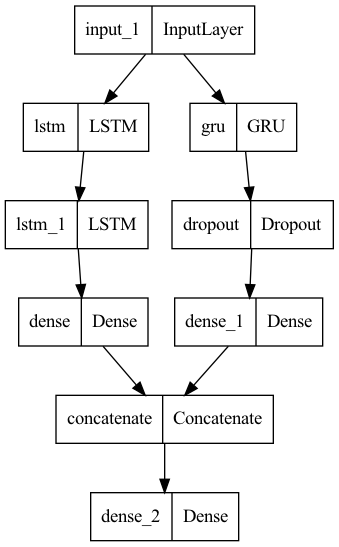

In [14]:
model.summary()
plot_model(model)

In [15]:
model.compile(optimizer='adam' , loss = 'mse')
model.fit(btcTrainGenny, validation_data = btcValGenny , epochs =100 , verbose = 1 )

Epoch 1/100
 8222/27416 [=======>......................] - ETA: 7:15 - loss: 0.0014

KeyboardInterrupt: 

<Strong> Temporal Neural Network </Strong>

In [93]:
#Filters perform the convolutions on the data
#We dont have to change out input data for the temporal neural network
#TCN implementation has the shape (batch_size, input_length, input_size) 
#conv1d vs conv2d
#Zero padding is applied so the input and output are the same length , apply the padding to the lest of input
#padding = size of kernel - 1 , for a layer

# For full coverage we need 4 layers (we are using a base of 2)
model = models.Sequential()

# Casual adds padding to the start of input sequence
model.add(Conv1D(filters=4, kernel_size=3, activation='relu', input_shape=(window_length, 1), dilation_rate=1 , padding = 'causal'))

model.add(Conv1D(filters=4, kernel_size=3, activation='relu' , padding = 'causal', dilation_rate=2))

# For full coverage we need 4 layers 
model.add(Conv1D(filters=4, kernel_size=3, activation='relu' , padding = 'causal' , dilation_rate=4))

# For full coverage we need 4 layers 
model.add(Conv1D(filters=4, kernel_size=3, activation='relu' , padding = 'causal', dilation_rate= 8))


model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_79 (Conv1D)          (None, 24, 4)             16        
                                                                 
 conv1d_80 (Conv1D)          (None, 24, 4)             52        
                                                                 
 conv1d_81 (Conv1D)          (None, 24, 4)             52        
                                                                 
 conv1d_82 (Conv1D)          (None, 24, 4)             52        
                                                                 
Total params: 172
Trainable params: 172
Non-trainable params: 0
_________________________________________________________________
